# Gate Cutting to Reduce Circuit Width

In this notebook, we will work through the steps of a [Qiskit pattern](https://docs.quantum.ibm.com/guides/intro-to-patterns) while using **circuit cutting** to reduce the number of qubits in a circuit.  We will cut gates to enable us to reconstruct the expectation value of a four-qubit circuit using only two-qubit experiments.

These are the steps that we will take:

- **Step 1: Map problem to quantum circuits and operators**:
    - Map the hamiltonian onto a quantum circuit.
- **Step 2: Optimize for target hardware** [_Uses the cutting addon_]:
    - <font color='#0F62FE'>Cut the circuit and observable.</font>
    - Transpile the subexperiments for hardware.
- **Step 3: Execute on target hardware**:
    - Run the subexperiments obtained in Step 2 using a `Sampler` primitive.
- **Step 4: Post-process results** [_Uses the cutting addon_]:
    - <font color='#0F62FE'>Combine the results of Step 3 to reconstruct the expectation value of the observable in question.</font>

## Step 1: Map

### Create a circuit to cut

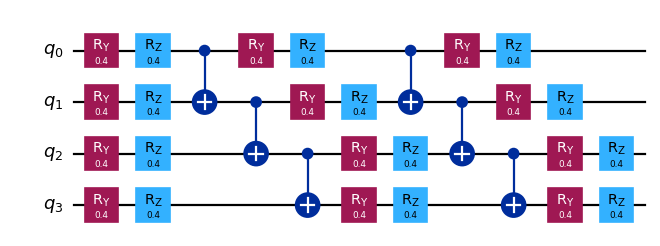

In [1]:
from qiskit.circuit.library import efficient_su2

qc = efficient_su2(4, entanglement="linear", reps=2)
qc.assign_parameters([0.4] * len(qc.parameters), inplace=True)

qc.draw("mpl", scale=0.8)

### Specify an observable

In [2]:
from qiskit.quantum_info import SparsePauliOp

observable = SparsePauliOp(["ZZII", "IZZI", "-IIZZ", "XIXI", "ZIZZ", "IXIX"])

## Step 2: Optimize

### Separate the circuit and observable according to a specified qubit partitioning

Each label in `partition_labels` corresponds to the `circuit` qubit in the same index. Qubits sharing a common partition label will be grouped together, and non-local gates spanning more than one partition will be cut.

**Note:** The ``observables`` kwarg to `partition_problem` is of type `PauliList`. Observable term coefficients and phases are ignored during decomposition of the problem and execution of the subexperiments. They may be re-applied during reconstruction of the expectation value.

In [3]:
from qiskit_addon_cutting import partition_problem

partitioned_problem = partition_problem(
    circuit=qc, partition_labels="AABB", observables=observable.paulis
)
subcircuits = partitioned_problem.subcircuits
subobservables = partitioned_problem.subobservables
bases = partitioned_problem.bases

### Visualize the decomposed problem

In [4]:
subobservables

{'A': PauliList(['II', 'ZI', 'ZZ', 'XI', 'ZZ', 'IX']),
 'B': PauliList(['ZZ', 'IZ', 'II', 'XI', 'ZI', 'IX'])}

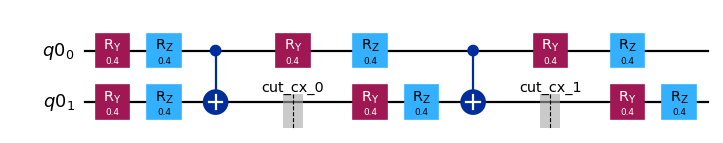

In [5]:
subcircuits["A"].draw("mpl", scale=0.8)

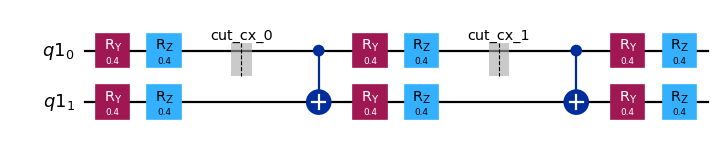

In [6]:
subcircuits["B"].draw("mpl", scale=0.8)

### Calculate the sampling overhead for the chosen cuts

Here we cut two CNOT gates, resulting in a sampling overhead of $9^2$.

For more on the sampling overhead incurred by circuit cutting, refer to the [explanatory material](../explanation/index.rst).

In [7]:
import numpy as np

print(f"Sampling overhead: {np.prod([basis.overhead for basis in bases])}")

Sampling overhead: 81.0


### Generate the subexperiments to run on the backend

`generate_cutting_experiments` accepts `circuits`/`observables` args as dictionaries mapping qubit partition labels to the respective `subcircuit`/`subobservables`.

To simulate the expectation value of the full-sized circuit, many subexperiments are generated from the decomposed gates' joint quasiprobability distribution and then executed on one or more backends. The number of samples taken from the distribution is controlled by `num_samples`, and one combined coefficient is given for each unique sample. For more information on how the coefficients are calculated, refer to the [explanatory material](../explanation/index.rst).

In [8]:
from qiskit_addon_cutting import generate_cutting_experiments

subexperiments, coefficients = generate_cutting_experiments(
    circuits=subcircuits, observables=subobservables, num_samples=np.inf
)

### Choose a backend

Here we are using a fake backend, which will result in Qiskit Runtime running in local mode (i.e., on a local simulator).

In [9]:
from qiskit_ibm_runtime.fake_provider import FakeManilaV2

backend = FakeManilaV2()

### Prepare the subexperiments for the backend

We must transpile the circuits with our backend as the target before submitting them to Qiskit Runtime.

In [10]:
from qiskit.transpiler import generate_preset_pass_manager

# Transpile the subexperiments to ISA circuits
pass_manager = generate_preset_pass_manager(optimization_level=1, backend=backend)
isa_subexperiments = {
    label: pass_manager.run(partition_subexpts)
    for label, partition_subexpts in subexperiments.items()
}

## Step 3: Execute

### Run the subexperiments using the Qiskit Runtime Sampler primitive

In [11]:
from qiskit_ibm_runtime import SamplerV2, Batch

# Submit each partition's subexperiments to the Qiskit Runtime Sampler
# primitive, in a single batch so that the jobs will run back-to-back.
with Batch(backend=backend) as batch:
    sampler = SamplerV2(mode=batch)
    jobs = {
        label: sampler.run(subsystem_subexpts, shots=2**12)
        for label, subsystem_subexpts in isa_subexperiments.items()
    }

/home/garrison/Qiskit/qiskit-ibm-runtime/qiskit_ibm_runtime/session.py:157: UserWarning: Session is not supported in local testing mode or when using a simulator.
  warnings.warn(


In [12]:
# Retrieve results
results = {label: job.result() for label, job in jobs.items()}

## Step 4: Post-process

### Reconstruct the expectation value

Reconstruct expectation values for each observable term and combine them to reconstruct the expectation value for the original observable.

In [12]:
from qiskit_addon_cutting import reconstruct_expectation_values

# Get expectation values for each observable term
reconstructed_expval_terms = reconstruct_expectation_values(
    results,
    coefficients,
    subobservables,
)

# Reconstruct final expectation value
reconstructed_expval = np.dot(reconstructed_expval_terms, observable.coeffs)

### Compare the reconstructed expectation value with the exact expectation value from the original circuit and observable

In [13]:
from qiskit_aer.primitives import EstimatorV2

estimator = EstimatorV2()
exact_expval = estimator.run([(qc, observable)]).result()[0].data.evs
print(f"Reconstructed expectation value: {np.real(np.round(reconstructed_expval, 8))}")
print(f"Exact expectation value: {np.round(exact_expval, 8)}")
print(f"Error in estimation: {np.real(np.round(reconstructed_expval-exact_expval, 8))}")
print(
    f"Relative error in estimation: {np.real(np.round((reconstructed_expval-exact_expval) / exact_expval, 8))}"
)

Reconstructed expectation value: 0.6991539
Exact expectation value: 0.56254612
Error in estimation: 0.13660778
Relative error in estimation: 0.24283836
